<a href="https://colab.research.google.com/github/greo234/telediagnosiswithBERT/blob/main/BERT_4_Prognosis_by_Omoregbe_Olotu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing libaries

import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read(file):
    """
    Read a CSV file into a pandas DataFrame.

    Args:
    file (str): The file path or URL to the CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing the data from the CSV file.
    """
    try:
        # Attempt to read the CSV file
        data = pd.read_csv(file)
        print("File loaded successfully.")
        return data
    except FileNotFoundError:
        print("Error: The file was not found. Please check the file path.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty. Please check the file content.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed. Please check the file format.")
    except Exception as e:
        print(f"An error occurred: {e}")


In [3]:
#Loading dataset from my github

filepath = 'https://raw.githubusercontent.com/greo234/telediagnosiswithBERT/main/text%20and%20symptoms_2.csv'

df = read(filepath)
df.drop(df.columns[0], axis=1, inplace=True)
df

File loaded successfully.


,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis
...,...,...
1195,I'm shaking and trembling all over. I've lost ...,diabetes
1196,"Particularly in the crevices of my skin, I hav...",diabetes
1197,I regularly experience these intense urges and...,diabetes
1198,"I have trouble breathing, especially outside. ...",diabetes


**EXPLORATORY DATA ANALYSIS**

Exploring how the dataset to draw insight as to give insight on what will be needed for the task. The dataset appears to be evenly distributed across disease categories with no missing values.

In [4]:
#dataframe headings

df.head()

,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis


In [5]:
#checking for missing values in the dataset

df.isnull().sum()

Patient_Problem    0
Disease            0
dtype: int64

In [6]:
#disease count
disease_count = df['Disease'].value_counts()
disease_count

Disease
Psoriasis                          50
Varicose Veins                     50
Typhoid                            50
Chicken pox                        50
Impetigo                           50
Dengue                             50
Fungal infection                   50
Common Cold                        50
Pneumonia                          50
Dimorphic Hemorrhoids              50
Arthritis                          50
Acne                               50
Bronchial Asthma                   50
Hypertension                       50
Migraine                           50
Cervical spondylosis               50
Jaundice                           50
Malaria                            50
urinary tract infection            50
allergy                            50
gastroesophageal reflux disease    50
drug reaction                      50
peptic ulcer disease               50
diabetes                           50
Name: count, dtype: int64

<ipython-input-7-8db160a595d0>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


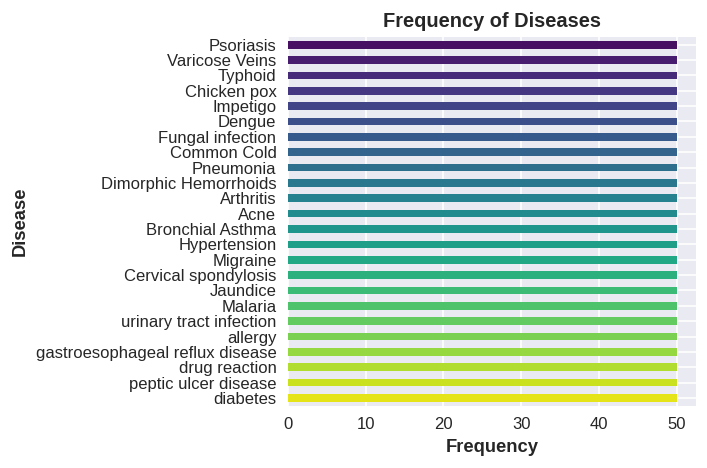

In [7]:

# Generate a color palette with the same number of colors as there are diseases
colors = sns.color_palette('viridis', n_colors=len(disease_count))

# Plot the disease count
plt.style.use('seaborn')
plt.figure(figsize=(6, 4), dpi=120)
disease_count.plot(kind='barh', color=colors)
plt.title('Frequency of Diseases', fontweight='bold')
plt.xlabel('Frequency', fontweight='bold')
plt.ylabel('Disease', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
#Total Number of diseases
print('Total number of Diseases: %d'%(len(df['Disease'].value_counts().index)))

#Calculate question lengths
df['Sentence Length'] = df['Patient_Problem'].apply(len)

# Maximum length of the sentence
max_length = df['Sentence Length'].max()

# Median length of the sentence
median_length = df['Sentence Length'].median()

# Minimum length of the sentence
min_length = df['Sentence Length'].min()

# Printing the results
print(f"Maximum sentence length: {max_length}")
print(f"Median sentence length: {median_length}")
print(f"Minimum sentence length: {min_length}")

Total number of Diseases: 24
Maximum sentence length: 317
Median sentence length: 170.0
Minimum sentence length: 60


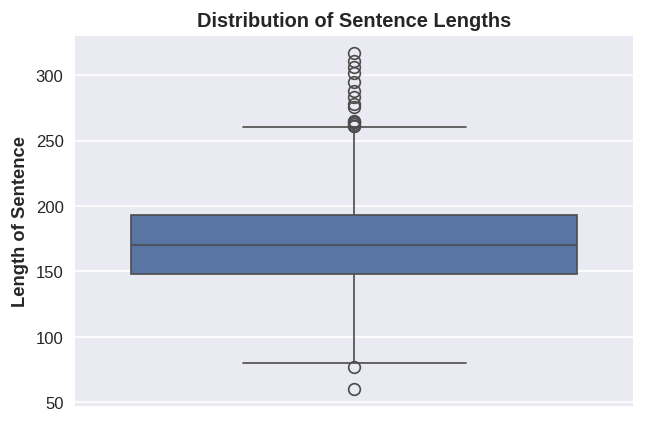

In [9]:

# Box plot for question lengths
plt.figure(figsize=(6, 4), dpi=120)
sns.boxplot(y=df['Sentence Length'])
plt.title('Distribution of Sentence Lengths', fontweight='bold')
plt.ylabel('Length of Sentence', fontweight='bold')
plt.show()


**PREPROCESSING FOR DIAGNOSTIC CLASSIFICATION**


The steps taken which is data split is necessary for training the model and evaluating its performance on unseen data. Tokenisation was done across the patient disease description column across the split datasets by using the BERT tokenizer while Label Encoder was used on the encode the diseases into ordinal numerical numbers for easy classification

In [10]:
from sklearn.model_selection import train_test_split
med_data = df
# Splitting the dataset into training and test sets for 'Patient_Problem' and 'Disease'
X, y_disease = med_data['Patient_Problem'], med_data['Disease']
X_train, problem_test, y_disease_train, disease_test = train_test_split(X, y_disease, stratify=y_disease, test_size=0.1, random_state=4612)

# Further splitting the training set into training and validation sets
problem_train, problem_val, disease_train, disease_val = train_test_split(X_train, y_disease_train, stratify=y_disease_train, test_size=0.20, random_state=4612)


In [11]:
# number of samples across dataset
print(f"samples in training set: {problem_train.shape[0]}\nsamples in validation set: {problem_val.shape[0]}\nsamples in test set: {problem_test.shape[0]}")


samples in training set: 864
samples in validation set: 216
samples in test set: 120


In [12]:
# Calculate the frequency of diseases in the training set
disease_train_frequency = disease_train.value_counts()

# Calculate the frequency of diseases in the validation set
disease_val_frequency = disease_val.value_counts()

# Calculate the frequency of diseases in the test set
disease_test_frequency = disease_test.value_counts()

# Optionally, you can print these frequencies
print("Disease Frequency in Training Set:\n", disease_train_frequency)
print("Disease Frequency in Validation Set:\n", disease_val_frequency)
print("Disease Frequency in Test Set:\n", disease_test_frequency)



Disease Frequency in Training Set:
 Disease
gastroesophageal reflux disease    36
Pneumonia                          36
allergy                            36
Bronchial Asthma                   36
Impetigo                           36
Jaundice                           36
Chicken pox                        36
drug reaction                      36
diabetes                           36
Migraine                           36
Acne                               36
Dimorphic Hemorrhoids              36
peptic ulcer disease               36
Hypertension                       36
Cervical spondylosis               36
Dengue                             36
Arthritis                          36
Psoriasis                          36
Common Cold                        36
urinary tract infection            36
Typhoid                            36
Fungal infection                   36
Malaria                            36
Varicose Veins                     36
Name: count, dtype: int64
Disease Frequency 

<ipython-input-13-241491adfa89>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.values, y=disease_counts.index, palette='viridis')


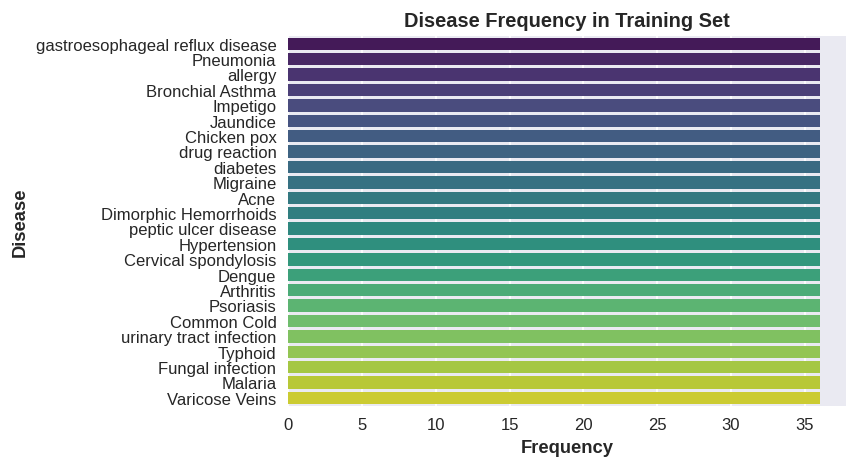

<ipython-input-13-241491adfa89>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.values, y=disease_counts.index, palette='viridis')


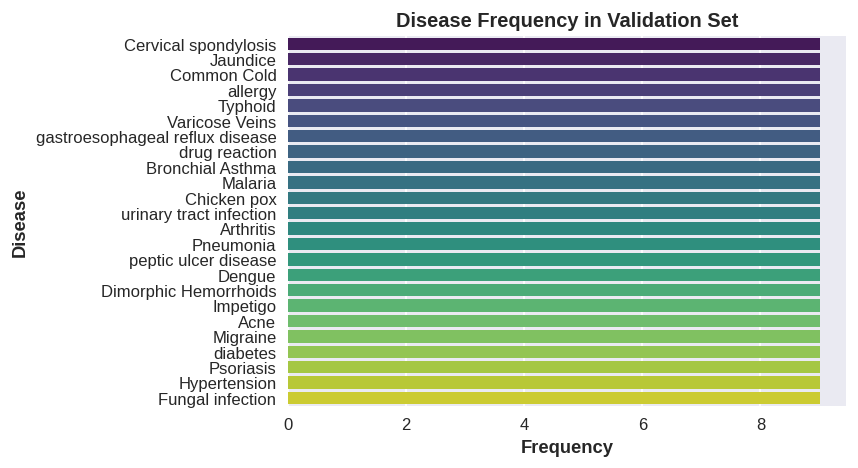

<ipython-input-13-241491adfa89>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.values, y=disease_counts.index, palette='viridis')


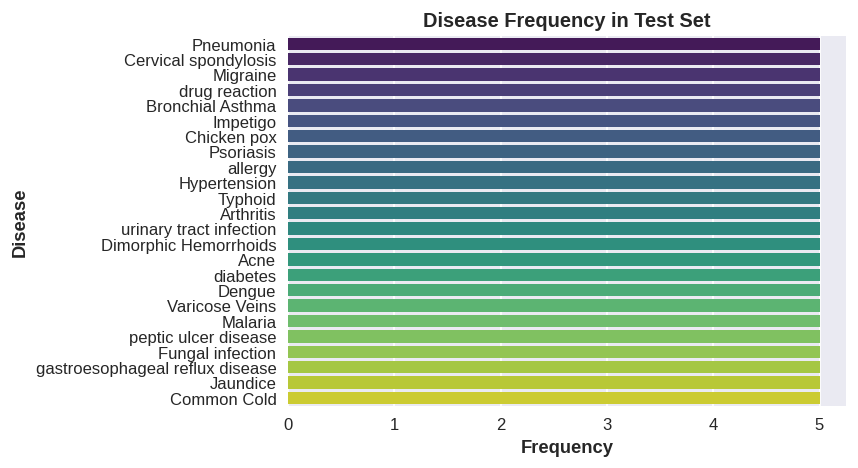

In [13]:
# Define a function to create bar plots for disease frequency
def plot_disease_frequency(disease_counts, title):
    plt.figure(figsize=(6, 4), dpi=120)
    sns.barplot(x=disease_counts.values, y=disease_counts.index, palette='viridis')
    plt.title(title, fontweight='bold')
    plt.xlabel('Frequency', fontweight='bold')
    plt.ylabel('Disease', fontweight='bold')
    plt.show()

# Plot disease frequency for training, validation, and test sets
plot_disease_frequency(disease_train_frequency, 'Disease Frequency in Training Set')
plot_disease_frequency(disease_val_frequency, 'Disease Frequency in Validation Set')
plot_disease_frequency(disease_test_frequency, 'Disease Frequency in Test Set')

In [14]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer with a pretrained model (e.g., 'bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

max_len = 0
input_ids = []

# For every problem...
for problem in problem_train:
    # Tokenize the problem and add special tokens--`[CLS]` and `[SEP]` tokens.
    tokens = tokenizer.encode(problem, add_special_tokens=True)
    input_ids.append(tokens)

    # Update the maximum sentence length.
    max_len = max(max_len, len(tokens))

# Calculate mean sentence length
mean_len = sum(len(tokens) for tokens in input_ids) / len(input_ids)

# Print the results
print('Max sentence length: %d \nMean sentence length: %d' % (max_len, mean_len))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Max sentence length: 79 
Mean sentence length: 43


In [15]:
def tokenize(problem):
  """
    Tokenize patient problems using the specified tokenizer.

    Returns:
    dict: Dictionary containing the tokenized inputs.
    """
  batch = tokenizer(list(problem),
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch


In [16]:
token_train = tokenize(problem_train)
token_val = tokenize(problem_val)
token_test = tokenize(problem_test)

In [17]:
# Check the type and shape of the tokenized data
print(type(token_train))
print(len(token_train))

# Print the first few examples of the tokenized data
print(token_train[:5])

<class 'transformers.tokenization_utils_base.BatchEncoding'>
3
{'input_ids': tensor([[  101,   146,  1579,  1243,   170, 17948,  5080,  1107,  1139,  1779,
           117,  1256,  1165,   146,  1274,   112,   189,  1138,  1625, 27675,
          1107,  1139,  3472,   119,   146,  4857,  1138,  1103, 20844, 19515,
         17210,  1105,   170, 13094,  1107,  1139,  2922,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1422, 10880,  1110,  1541,  1344,   117,  1105,   146,   112,
           182,  1515,  3819,  9256,  1139,  2184,   119,   146,   112,   182,
         21234,   170,  1974,   117,  2296,  2504,  1105,  4871,   117,  1105,
          1139,  1762,  1110,  5405,  1541,  2698,   119,   

In [18]:
print("Input IDs:")
print(token_train['input_ids'][0])

# Print token type IDs for the first training example
print("Token Type IDs:")
print(token_train['token_type_ids'][0])

# Print attention mask for the first training example
print("Attention Mask:")
print(token_train['attention_mask'][0])

Input IDs:
tensor([  101,   146,  1579,  1243,   170, 17948,  5080,  1107,  1139,  1779,
          117,  1256,  1165,   146,  1274,   112,   189,  1138,  1625, 27675,
         1107,  1139,  3472,   119,   146,  4857,  1138,  1103, 20844, 19515,
        17210,  1105,   170, 13094,  1107,  1139,  2922,   119,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
Token Type IDs:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])
Attention Mask:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [20]:
from sklearn.preprocessing import LabelEncoder

#encoding the labels

LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(disease_train)))
label_val = torch.tensor((LE.fit_transform(disease_val)))
label_test = torch.tensor((LE.fit_transform(disease_test)))

In [21]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(token_train['input_ids'], token_train['attention_mask'],label_train)
val_data = TensorDataset(token_val['input_ids'], token_val['attention_mask'],label_val)
test_data = TensorDataset(token_test['input_ids'], token_test['attention_mask'],label_test)


**TRAINING THE MODEL**

The model was trained using the Categorical Cross Entropy Loss Function, which is well-suited for multi-class classification tasks. For optimisation, AdamW optimiser was employed, a variant of the Adam optimiser that is better suited for these types of models as it implements weight decay more effectively, preventing overfitting. The training process explored three different learning rates: 0.00001, 0.0001, and 0.001, to identify the optimal setting for convergence and performance. This was done over 10 epochs, with distinct batch sizes for training (32) and validation/testing (64). The smaller batch size during training was chosen to manage memory usage efficiently and introduce noise into the optimisation process, which can enhance generalization. In contrast, the larger batch size during validation and testing was intended to speed up computations and stabilise the evaluation metrics due to reduced variance in output scores.
Early stopping was implemented to halt the training process when there was no further improvement in validation loss. This helps prevent overfitting and saves computational resources by stopping training at the optimal moment.
This approach ensures that the model retained is the one that performs best on unseen data, based on its accuracy on the validation set. The best model configuration was identified and saved for future use, allowing for reproducibility and further validation or real-world application without the need to retrain.



In [ ]:
import datetime
import random
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define learning rates
learning_rates = [0.00001, 0.0001, 0.001]

# Define epochs and batch sizes
epochs = 10
batch_size = 32
val_batch = 64
# Initialize dictionaries to store metrics for each learning rate
train_metrics = {}
valid_metrics = {}

# Initialize variables to track the best performing model
best_valid_accuracy = 0
best_model_state_dict = None
best_metrics = {}

# Early stopping parameters
patience = 3
early_stopping_counter = 0

def train_and_get_best_model(epochs=epochs, batch_size=batch_size, val_batch=val_batch, train_metrics=train_metrics, valid_metrics=valid_metrics,
                             patience=patience, early_stopping_counter=early_stopping_counter):
  global best_valid_accuracy, best_model_state_dict, best_metrics
  for lr in learning_rates:
      print(f"Training with learning rate: {lr}")

      # Initialize the model
      model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=24)
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model.to(device)

      # Define data loaders for training and validation
      train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
      valid_dataloader = DataLoader(val_data, batch_size=val_batch, shuffle=False)

      # Initialize optimizer and scheduler
      optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
      total_steps = len(train_dataloader) * epochs
      scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

      # Initialize lists to store metrics for this learning rate
      train_loss_list = []
      train_recall_list = []
      train_f1_list = []
      train_roc_auc_list = []
      train_accuracy_list = []
      train_precision_list = []
      valid_loss_list = []
      valid_recall_list = []
      valid_f1_list = []
      valid_roc_auc_list = []
      valid_accuracy_list = []
      valid_precision_list = []

      # Start the training process
      for epoch in range(epochs):
          model.train()
          total_train_loss = 0
          total_train_accuracy = 0
          total_train_precision = 0
          train_predictions = []
          train_labels = []

          for step, batch in enumerate(train_dataloader):
              # Forward pass
              inputs = {'input_ids': batch[0].to(device),
                        'attention_mask': batch[1].to(device),
                        'labels': batch[2].to(device)}
              outputs = model(**inputs)
              loss = outputs.loss
              logits = outputs.logits

              # Backward pass
              optimizer.zero_grad()
              loss.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
              scheduler.step()

              # Calculate training loss
              total_train_loss += loss.item()

              # Calculate training accuracy
              predictions = torch.argmax(logits, dim=1)
              accuracy = (predictions == inputs['labels']).sum().item() / len(predictions)
              total_train_accuracy += accuracy

              # Calculate training precision
              precision = precision_score(inputs['labels'].cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted', zero_division=0)
              total_train_precision += precision

              # Store predictions and labels for computing metrics
              train_predictions.extend(predictions.cpu().detach().numpy())
              train_labels.extend(inputs['labels'].cpu().detach().numpy())

          # Calculate average training loss
          avg_train_loss = total_train_loss / len(train_dataloader)

          # Calculate average training accuracy
          avg_train_accuracy = total_train_accuracy / len(train_dataloader)

          # Calculate average training precision
          avg_train_precision = total_train_precision / len(train_dataloader)

          # Calculate training metrics
          train_recall = recall_score(train_labels, train_predictions, average='weighted')
          train_f1 = f1_score(train_labels, train_predictions, average='weighted')
          train_roc_auc = roc_auc_score(label_binarize(train_labels, classes=np.arange(24)),
                                        label_binarize(train_predictions, classes=np.arange(24)),
                                        average='weighted')

          # Print and store metrics
          print(f"Epoch {epoch + 1}/{epochs}:")
          print(f"  Training Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, Recall: {train_recall:.4f}, "
                f"F1: {train_f1:.4f}, AROC: {train_roc_auc:.4f}, Precision: {avg_train_precision:.4f}")

          train_loss_list.append(avg_train_loss)
          train_recall_list.append(train_recall)
          train_f1_list.append(train_f1)
          train_roc_auc_list.append(train_roc_auc)
          train_accuracy_list.append(avg_train_accuracy)
          train_precision_list.append(avg_train_precision)

          # Validation loop
          model.eval()
          total_valid_loss = 0
          total_valid_accuracy = 0
          total_valid_precision = 0
          valid_predictions = []
          valid_labels = []

          with torch.no_grad():
              for batch in valid_dataloader:
                  # Forward pass
                  inputs = {'input_ids': batch[0].to(device),
                            'attention_mask': batch[1].to(device),
                            'labels': batch[2].to(device)}
                  outputs = model(**inputs)
                  loss = outputs.loss
                  logits = outputs.logits

                  # Calculate validation loss
                  total_valid_loss += loss.item()

                  # Calculate validation accuracy
                  predictions = torch.argmax(logits, dim=1)
                  accuracy = (predictions == inputs['labels']).sum().item() / len(predictions)
                  total_valid_accuracy += accuracy

                  # Calculate validation precision
                  precision = precision_score(inputs['labels'].cpu().detach().numpy(),
                                              predictions.cpu().detach().numpy(), average='weighted',
                                              zero_division=0) #, zero_division="warn"
                  total_valid_precision += precision

                  # Store predictions and labels for computing metrics
                  valid_predictions.extend(predictions.cpu().detach().numpy())
                  valid_labels.extend(inputs['labels'].cpu().detach().numpy())

          # Calculate average validation loss
          avg_valid_loss = total_valid_loss / len(valid_dataloader)

          # Calculate average validation accuracy
          avg_valid_accuracy = total_valid_accuracy / len(valid_dataloader)

          # Calculate average validation precision
          avg_valid_precision = total_valid_precision / len(valid_dataloader)

          # Calculate validation metrics
          valid_recall = recall_score(valid_labels, valid_predictions, average='weighted')
          valid_f1 = f1_score(valid_labels, valid_predictions, average='weighted')
          valid_roc_auc = roc_auc_score(label_binarize(valid_labels, classes=np.arange(24)),
                                        label_binarize(valid_predictions, classes=np.arange(24)),
                                        average='weighted')

          # Print and store metrics
          print(f"  Validation Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_accuracy:.4f}, Recall: {valid_recall:.4f}, "
                f"F1: {valid_f1:.4f}, AROC: {valid_roc_auc:.4f}, Precision: {avg_valid_precision:.4f}")

          valid_loss_list.append(avg_valid_loss)
          valid_recall_list.append(valid_recall)
          valid_f1_list.append(valid_f1)
          valid_roc_auc_list.append(valid_roc_auc)
          valid_accuracy_list.append(avg_valid_accuracy)
          valid_precision_list.append(avg_valid_precision)

          # Update best performing model based on validation accuracy
          if avg_valid_accuracy > best_valid_accuracy:
              best_valid_accuracy = avg_valid_accuracy
              best_model_state_dict = model.state_dict()
              best_metrics = {
                  'learning_rate': lr,
                  'epoch': epoch + 1,
                  'train_loss': avg_train_loss,
                  'valid_loss': avg_valid_loss,
                  'train_accuracy': avg_train_accuracy,
                  'valid_accuracy': avg_valid_accuracy,
                  'train_recall': train_recall,
                  'valid_recall': valid_recall,
                  'train_f1': train_f1,
                  'valid_f1': valid_f1,
                  'train_roc_auc': train_roc_auc,
                  'valid_roc_auc': valid_roc_auc,
                  'train_precision': avg_train_precision,
                  'valid_precision': avg_valid_precision
              }

          # Early stopping
          if epoch > 0 and valid_loss_list[-1] > valid_loss_list[-2]:
              early_stopping_counter += 1
              if early_stopping_counter >= patience:
                  print("Early stopping triggered.")
                  break
          else:
              early_stopping_counter = 0

      # Store metrics for this learning rate
      train_metrics[lr] = {
          'loss': train_loss_list,
          'recall': train_recall_list,
          'f1': train_f1_list,
          'roc_auc': train_roc_auc_list,
          'accuracy': train_accuracy_list,
          'precision': train_precision_list
      }
      valid_metrics[lr] = {
          'loss': valid_loss_list,
          'recall': valid_recall_list,
          'f1': valid_f1_list,
          'roc_auc': valid_roc_auc_list,
          'accuracy': valid_accuracy_list,
          'precision': valid_precision_list
      }
  return model, train_metrics, valid_metrics
model, train_metrics, valid_metrics = train_and_get_best_model()
# After training loop, load the best model state
model.load_state_dict(best_model_state_dict)

# Print best performing model and its metrics
print("Best Performing Model Metrics:")
print(best_metrics)

Training with learning rate: 1e-05


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:
  Training Loss: 3.1678, Accuracy: 0.0544, Recall: 0.0544, F1: 0.0284, AROC: 0.5066, Precision: 0.0310
  Validation Loss: 3.0882, Accuracy: 0.0859, Recall: 0.1019, F1: 0.0677, AROC: 0.5314, Precision: 0.0670
Epoch 2/10:
  Training Loss: 2.9564, Accuracy: 0.2095, Recall: 0.2095, F1: 0.1863, AROC: 0.5876, Precision: 0.1861
  Validation Loss: 2.8269, Accuracy: 0.3359, Recall: 0.3287, F1: 0.2686, AROC: 0.6498, Precision: 0.3083
Epoch 3/10:
  Training Loss: 2.6872, Accuracy: 0.4016, Recall: 0.4016, F1: 0.3555, AROC: 0.6878, Precision: 0.3718
  Validation Loss: 2.5044, Accuracy: 0.5690, Recall: 0.5741, F1: 0.5039, AROC: 0.7778, Precision: 0.5100
Epoch 4/10:
  Training Loss: 2.3932, Accuracy: 0.5880, Recall: 0.5880, F1: 0.5321, AROC: 0.7850, Precision: 0.5612
  Validation Loss: 2.2305, Accuracy: 0.6641, Recall: 0.6713, F1: 0.6087, AROC: 0.8285, Precision: 0.6306
Epoch 5/10:
  Training Loss: 2.1692, Accuracy: 0.6678, Recall: 0.6678, F1: 0.6170, AROC: 0.8267, Precision: 0.6470
  Val

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:
  Training Loss: 2.8931, Accuracy: 0.2627, Recall: 0.2627, F1: 0.2496, AROC: 0.6153, Precision: 0.2532
  Validation Loss: 2.0263, Accuracy: 0.7044, Recall: 0.7037, F1: 0.6494, AROC: 0.8454, Precision: 0.6629
Epoch 2/10:
  Training Loss: 1.4242, Accuracy: 0.8044, Recall: 0.8044, F1: 0.7850, AROC: 0.8979, Precision: 0.8075
  Validation Loss: 0.8017, Accuracy: 0.8724, Recall: 0.8796, F1: 0.8618, AROC: 0.9372, Precision: 0.8417
Epoch 3/10:
  Training Loss: 0.5011, Accuracy: 0.9641, Recall: 0.9641, F1: 0.9632, AROC: 0.9813, Precision: 0.9700
  Validation Loss: 0.2751, Accuracy: 0.9609, Recall: 0.9537, F1: 0.9513, AROC: 0.9758, Precision: 0.9613
Epoch 4/10:
  Training Loss: 0.1424, Accuracy: 0.9907, Recall: 0.9907, F1: 0.9907, AROC: 0.9952, Precision: 0.9937
  Validation Loss: 0.1042, Accuracy: 0.9701, Recall: 0.9722, F1: 0.9718, AROC: 0.9855, Precision: 0.9728
Epoch 5/10:
  Training Loss: 0.0500, Accuracy: 0.9965, Recall: 0.9965, F1: 0.9965, AROC: 0.9982, Precision: 0.9949
  Val

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:
  Training Loss: 3.3872, Accuracy: 0.0347, Recall: 0.0347, F1: 0.0239, AROC: 0.4964, Precision: 0.0049
  Validation Loss: 3.3507, Accuracy: 0.0417, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0024
Epoch 2/10:
  Training Loss: 3.3272, Accuracy: 0.0463, Recall: 0.0463, F1: 0.0356, AROC: 0.5024, Precision: 0.0162
  Validation Loss: 3.2903, Accuracy: 0.0352, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0018
Epoch 3/10:
  Training Loss: 3.3180, Accuracy: 0.0336, Recall: 0.0336, F1: 0.0252, AROC: 0.4958, Precision: 0.0125
  Validation Loss: 3.2584, Accuracy: 0.0352, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0020
Epoch 4/10:
  Training Loss: 3.3005, Accuracy: 0.0301, Recall: 0.0301, F1: 0.0210, AROC: 0.4940, Precision: 0.0100
  Validation Loss: 3.2929, Accuracy: 0.0612, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0076
Epoch 5/10:
  Training Loss: 3.3077, Accuracy: 0.0347, Recall: 0.0347, F1: 0.0222, AROC: 0.4964, Precision: 0.0115
  Val

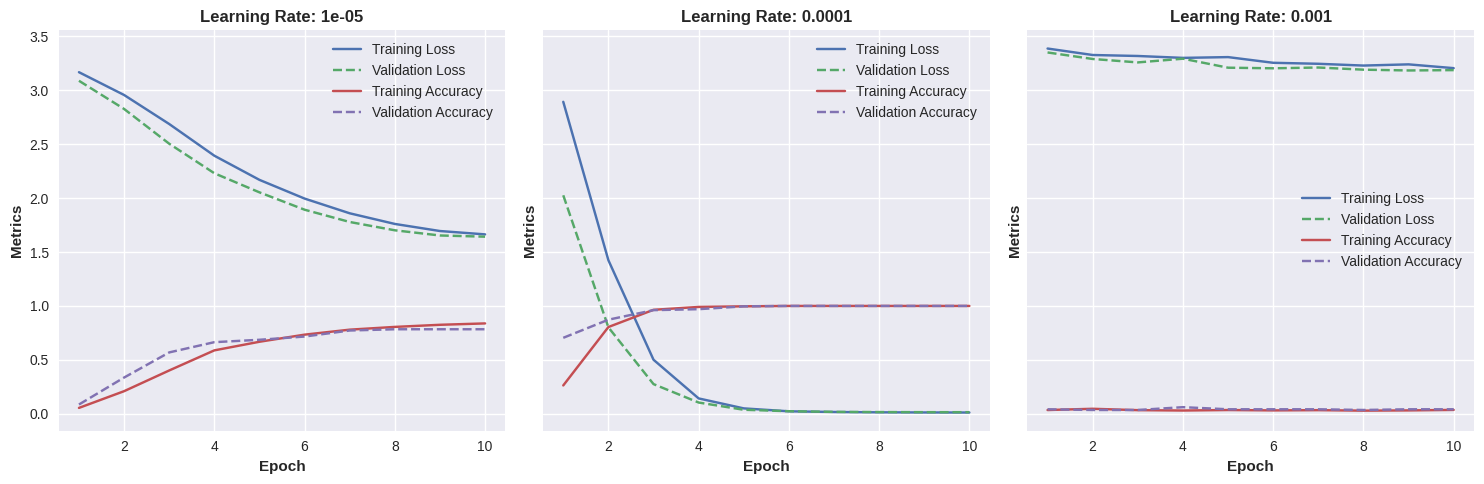

In [ ]:
# Plotting the metrics for each learning rate separately
fig, axs = plt.subplots(1, len(learning_rates), figsize=(5*len(learning_rates), 5), sharey=True)

# Loop through each learning rate
for i, lr in enumerate(learning_rates):
    ax = axs[i]
    ax.plot(range(1, len(train_metrics[lr]['loss']) + 1), train_metrics[lr]['loss'], label='Training Loss')
    ax.plot(range(1, len(valid_metrics[lr]['loss']) + 1), valid_metrics[lr]['loss'], label='Validation Loss', linestyle='--')
    ax.plot(range(1, len(train_metrics[lr]['accuracy']) + 1), train_metrics[lr]['accuracy'], label='Training Accuracy')
    ax.plot(range(1, len(valid_metrics[lr]['accuracy']) + 1), valid_metrics[lr]['accuracy'], label='Validation Accuracy', linestyle='--')
    ax.set_xlabel('Epoch', rotation=0, fontweight='bold')
    ax.set_ylabel('Metrics', fontweight='bold')
    ax.set_title(f'Learning Rate: {lr}', fontweight='bold')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


**SAVING THE MODEL**

This optimal model was saved Iin my Google Drive and used for testing and made accomodations to save model back to GPU/CPU depending on the availability of resources.


In [22]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directory path to save the model in Google Drive
model_dir_drive = '/content/drive/My Drive/BERT'

def save_model(model_dir_drive):
  # Create the directory if it doesn't exist
  os.makedirs(model_dir_drive, exist_ok=True)
  # Save the best model's state dictionary
  torch.save(best_model_state_dict, os.path.join(model_dir_drive, "best_model_state_dict.pth"))

  #save the tokenizer
  tokenizer.save_pretrained(model_dir_drive)

save_model(model_dir_drive)

In [23]:
#converting encoded labels to dataframe with their respective disease names

trained_label = pd.DataFrame(tuple(zip(range(24),LE.classes_)), columns=['id','disease'])
trained_label

,id,disease
0,0,Acne
1,1,Arthritis
2,2,Bronchial Asthma
3,3,Cervical spondylosis
4,4,Chicken pox
5,5,Common Cold
6,6,Dengue
7,7,Dimorphic Hemorrhoids
8,8,Fungal infection
9,9,Hypertension


**MODEL EVALUATION**

This loads the optimal model from the Google drive, ensures the model is on either GPU or CPU while deployed for testing and evaluation.


In [24]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Define the path to the saved model file
saved_model_path = "/content/drive/My Drive/BERT/best_model_state_dict.pth"

def load_model(model_path):
    """
    Load a trained BERT model from a saved state dictionary.

    Args:
    - model_path (str): Path to the model's saved state dictionary.

    Returns:
    - model (torch.nn.Module): Loaded model ready for predictions.
    """
    # Initialize the model architecture with the specified number of labels
    model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=24)

    # Load the model's state dictionary from the specified path
    model_state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(model_state_dict)

    # Ensure model is on the correct device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

# Load the model using the defined function
Telemodel = load_model(saved_model_path)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def plot_confusion_matrix(conf_matrix, classes):
    """
    This function prints and plots the confusion matrix.

    """
    plt.figure(figsize=(10, 8), dpi=140)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.show()


In [27]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(test_dataloader, model):
    model.eval()
    all_predictions = []
    all_labels = []

    # Class names directly from your provided data
    classes = trained_label['disease']

    for batch in test_dataloader:
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().tolist())
        all_labels.extend(inputs['labels'].cpu().tolist())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)

    plot_confusion_matrix(conf_matrix, classes)



Accuracy: 0.9916666666666667
Precision: 0.9930555555555556
Recall: 0.9916666666666667
F1-score: 0.9915824915824916
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]


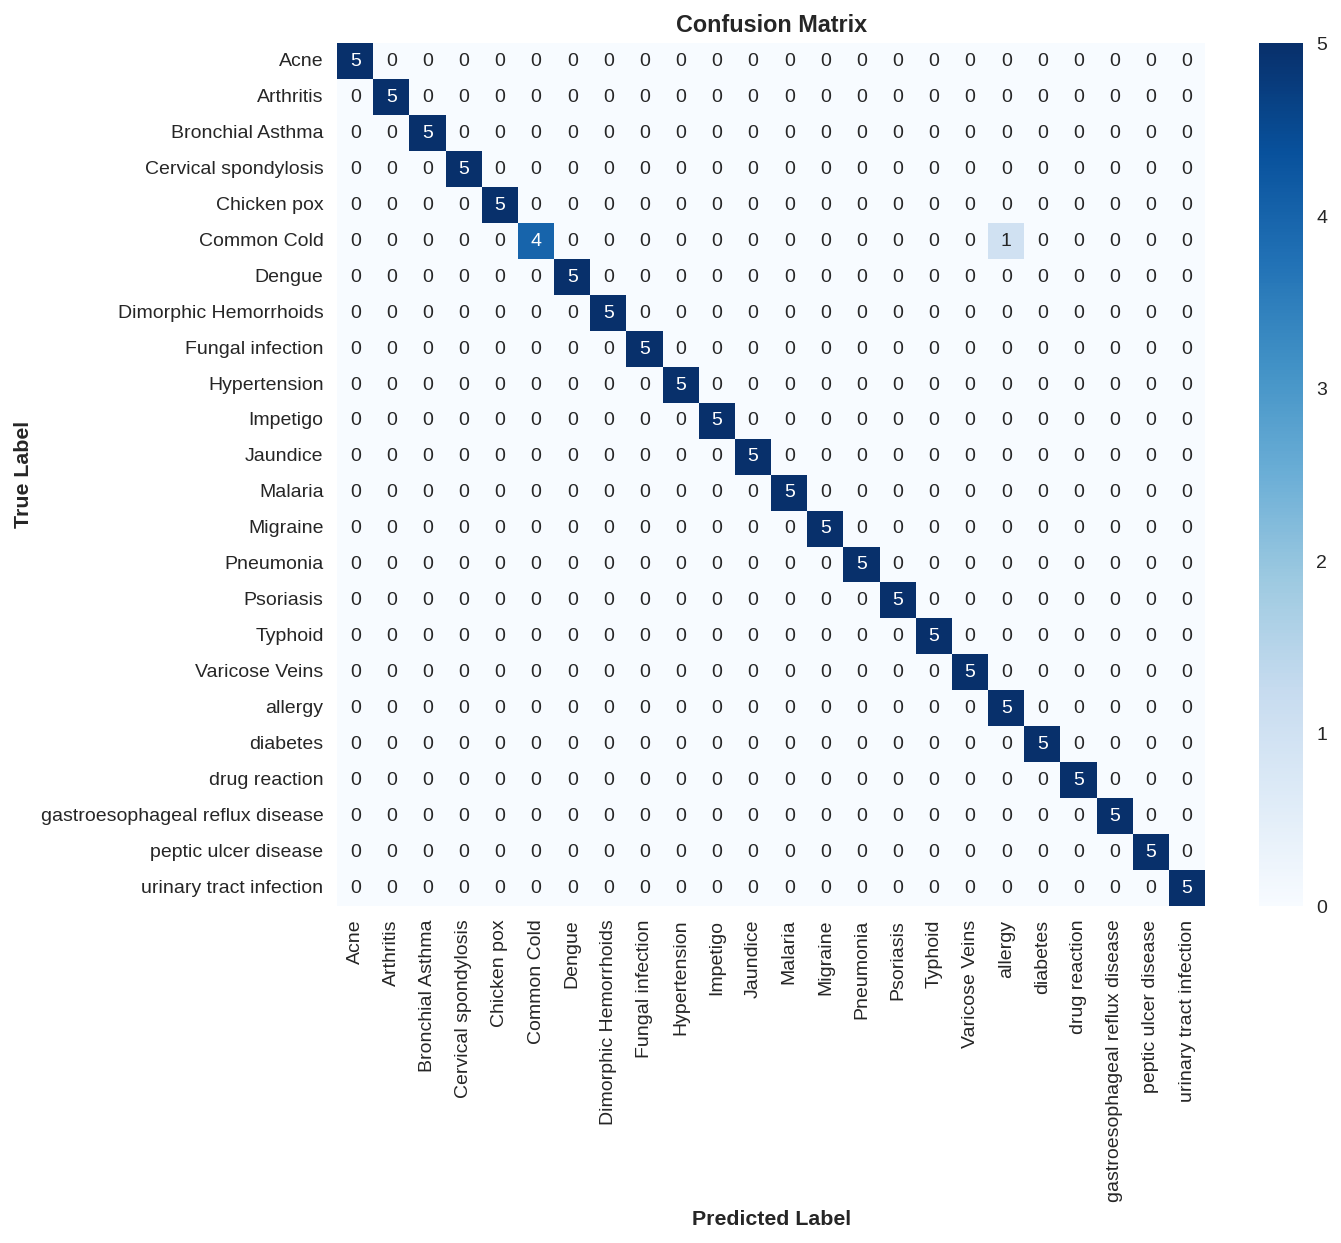

In [28]:
# Evaluate the model on the test data
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
evaluate_model(test_dataloader, Telemodel)

**EVALUATING ON RANDOM PATIENT COMPLAINTS**

This loads the saved optimal model and prototypes the use case of the model in real world applications

In [29]:
# Predefined variables
model_dir_drive = '/content/drive/My Drive/BERT'
Telemodel.eval()
model_tokenizer = BertTokenizer.from_pretrained(model_dir_drive)
loaded_label = trained_label.to_pickle

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Telemodel.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [30]:
import torch

def prognosis(description):
    # Tokenize the input description and prepare input tensor
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True)

    # Move input tensors to the same device as the model
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = Telemodel(**inputs)
        logits = outputs.logits

    # Count words in the input description
    word_count = len(description.split())

    # Depending on the length of the description, output top 1 or top 3 diseases
    if word_count < 8:
        # Get the indices of the top 3 predictions
        top_probs, top_indices = torch.topk(logits, 3, dim=1)
        likely_diseases = [trained_label.iloc[idx.item()]['disease'] for idx in top_indices[0]]
        response = f"Based on your symptoms, you may have one of these conditions: {', '.join(likely_diseases)}."
    else:
        # Get the index of the top 1 prediction
        _, predicted_index = torch.max(logits, dim=1)
        diagnosis = trained_label.iloc[predicted_index.item()]['disease']
        response = f"Based on your symptoms, you may have {diagnosis}."

    response += " Would you like me to book the next available appointment for you to see a doctor?"
    return response

In [32]:
# Example usage
description_short = "cold."
description_medium = "headache, fever"
description_long = "I am experiencing severe headache, fever, sneezing, and a runny nose."

print(prognosis(description_short))
print(prognosis(description_medium))
print(prognosis(description_long))

Based on your symptoms, you may have one of these conditions: Common Cold, drug reaction, Pneumonia. Would you like me to book the next available appointment for you to see a doctor?
Based on your symptoms, you may have one of these conditions: Chicken pox, Dengue, Typhoid. Would you like me to book the next available appointment for you to see a doctor?
Based on your symptoms, you may have allergy. Would you like me to book the next available appointment for you to see a doctor?
